# Binary Classification Model for Heart Disease Key Indicators Using TensorFlow
### David Lowe
### March 4, 2022

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Heart Disease Key Indicators dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: This dataset comes from the CDC's Behavioral Risk Factor Surveillance System (BRFSS) study, which conducts annual telephone surveys to gather data on the health status of U.S. residents. The original dataset consists of 401,958 rows and 279 columns. However, the Kaggle project owner selected some of the most relevant attributes from the dataset and cleaned it up for machine learning projects.

ANALYSIS: The performance of the preliminary TensorFlow model achieved a ROC/AUC benchmark of 84.16%. When we processed the test dataset with the final model, the model achieved a ROC/AUC score of 50.60%.

CONCLUSION: In this iteration, the TensorFlow model did not appear to be a suitable algorithm for modeling this dataset.

Dataset Used: Personal Key Indicators of Heart Disease Dataset

Dataset ML Model: Binary classification with numerical and categorical features

Dataset Reference: https://www.kaggle.com/kamilpytlak/personal-key-indicators-of-heart-disease

One source of potential performance benchmarks: https://www.kaggle.com/kamilpytlak/personal-key-indicators-of-heart-disease/code

## Task 1 - Prepare Environment

In [1]:
# Retrieve the GPU information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Mar  2 21:28:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:00:05.0 Off |                  Off |
| 33%   36C    P0    63W / 230W |      0MiB / 16125MiB |     16%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Retrieve the memory configuration
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 31.6 gigabytes of available RAM



In [3]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 8


In [4]:
# # Mount Google Drive locally for loading the dotenv files
# from dotenv import load_dotenv
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

In [8]:
# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.15
VAL_SET_RATIO = 0.15

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'binary_crossentropy'
DEFAULT_METRICS = [tf.keras.metrics.AUC()]
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
CLASSIFIER_ACTIVATION = 'sigmoid'
MAX_EPOCHS = 5
BATCH_SIZE = 32

# Define the directory locations and file names
TRAIN_DATASET = 'heart_2020_cleaned.csv'
# TEST_DATASET = ''

# Define the labels to use for graphing the data
TRAIN_METRIC = "auc"
VALIDATION_METRIC = "val_auc"
TRAIN_LOSS = "loss"
VALIDATION_LOSS = "val_loss"

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

2022-03-02 21:28:59.949947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Num GPUs Available: 1
TensorFlow version: 2.6.0


2022-03-02 21:28:59.961684: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 21:28:59.962561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 21:28:59.965219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 21:28:59.966035: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 21:28:59.966823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

In [9]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [10]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [11]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [12]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-kamilpytlak-heart-disease/heart_2020_cleaned.csv

In [13]:
df_dataset_import = pd.read_csv(TRAIN_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head(10))

  HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0           No  16.60     Yes              No     No             3.0   
1           No  20.34      No              No    Yes             0.0   
2           No  26.58     Yes              No     No            20.0   
3           No  24.21      No              No     No             0.0   
4           No  23.71      No              No     No            28.0   
5          Yes  28.87     Yes              No     No             6.0   
6           No  21.63      No              No     No            15.0   
7           No  31.64     Yes              No     No             5.0   
8           No  26.45      No              No     No             0.0   
9           No  40.69      No              No     No             0.0   

   MentalHealth DiffWalking     Sex  AgeCategory   Race  \
0          30.0          No  Female        55-59  White   
1           0.0          No  Female  80 or older  White   
2          30.0          No   

In [14]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [15]:
print(df_dataset_import.describe())

                 BMI  PhysicalHealth   MentalHealth      SleepTime
count  319795.000000    319795.00000  319795.000000  319795.000000
mean       28.325399         3.37171       3.898366       7.097075
std         6.356100         7.95085       7.955235       1.436007
min        12.020000         0.00000       0.000000       1.000000
25%        24.030000         0.00000       0.000000       6.000000
50%        27.340000         0.00000       0.000000       7.000000
75%        31.420000         2.00000       3.000000       8.000000
max        94.850000        30.00000      30.000000      24.000000


In [16]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64
Total number of NaN in the dataframe:  0


In [17]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('HeartDisease').size())

HeartDisease
No     292422
Yes     27373
dtype: int64


### 1.d) Data Cleaning

In [18]:
# Standardize the class column to the name of targetVar if required
# df_dataset_import = df_dataset_import.rename(columns={'HeartDisease': 'target'})

# Convert features with R/M levels into categorical feature of 0/1
def reclass_target(target):
    if target == 'Yes': return 1
    else: return 0
df_dataset_import['target'] = df_dataset_import['HeartDisease'].apply(reclass_target)

# Dropping features
df_dataset_import.drop(columns=['HeartDisease'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

     BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  MentalHealth  \
0  16.60     Yes              No     No             3.0          30.0   
1  20.34      No              No    Yes             0.0           0.0   
2  26.58     Yes              No     No            20.0          30.0   
3  24.21      No              No     No             0.0           0.0   
4  23.71      No              No     No            28.0           0.0   

  DiffWalking     Sex  AgeCategory   Race Diabetic PhysicalActivity  \
0          No  Female        55-59  White      Yes              Yes   
1          No  Female  80 or older  White       No              Yes   
2          No    Male        65-69  White      Yes              Yes   
3          No  Female        75-79  White       No               No   
4         Yes  Female        40-44  White       No              Yes   

   GenHealth  SleepTime Asthma KidneyDisease SkinCancer  target  
0  Very good        5.0    Yes            No        Yes       0  
1 

In [19]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   BMI               319795 non-null  float64
 1   Smoking           319795 non-null  object 
 2   AlcoholDrinking   319795 non-null  object 
 3   Stroke            319795 non-null  object 
 4   PhysicalHealth    319795 non-null  float64
 5   MentalHealth      319795 non-null  float64
 6   DiffWalking       319795 non-null  object 
 7   Sex               319795 non-null  object 
 8   AgeCategory       319795 non-null  object 
 9   Race              319795 non-null  object 
 10  Diabetic          319795 non-null  object 
 11  PhysicalActivity  319795 non-null  object 
 12  GenHealth         319795 non-null  object 
 13  SleepTime         319795 non-null  float64
 14  Asthma            319795 non-null  object 
 15  KidneyDisease     319795 non-null  object 
 16  SkinCancer        31

In [20]:
print(df_dataset_import.describe())

                 BMI  PhysicalHealth   MentalHealth      SleepTime  \
count  319795.000000    319795.00000  319795.000000  319795.000000   
mean       28.325399         3.37171       3.898366       7.097075   
std         6.356100         7.95085       7.955235       1.436007   
min        12.020000         0.00000       0.000000       1.000000   
25%        24.030000         0.00000       0.000000       6.000000   
50%        27.340000         0.00000       0.000000       7.000000   
75%        31.420000         2.00000       3.000000       8.000000   
max        94.850000        30.00000      30.000000      24.000000   

              target  
count  319795.000000  
mean        0.085595  
std         0.279766  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  


In [21]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
target              0
dtype: int64
Total number of NaN in the dataframe:  0


In [22]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('target').size())

target
0    292422
1     27373
dtype: int64


### 1.e) Splitting Data into Sets

In [23]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_import = df_dataset_import['target']
df_features_import = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_import.shape: {} df_target_import.shape: {}".format(df_dataset_import.shape, df_features_import.shape, df_target_import.shape))

df_dataset_import.shape: (319795, 18) df_features_import.shape: (319795, 17) df_target_import.shape: (319795,)


In [24]:
# Split the data further into training and test datasets
df_features_train, df_features_test, df_target_train, df_target_test = train_test_split(df_features_import, df_target_import,
                                                                                        test_size=TEST_SET_RATIO, random_state=RNG_SEED,
                                                                                        stratify=df_dataset_import['target'])
print("df_features_train.shape: {} df_target_train.shape: {}".format(df_features_train.shape, df_target_train.shape))
print("df_features_test.shape: {} df_target_test.shape: {}".format(df_features_test.shape, df_target_test.shape))

df_features_train.shape: (271825, 17) df_target_train.shape: (271825,)
df_features_test.shape: (47970, 17) df_target_test.shape: (47970,)


### 1.f) Set up the parameters for data visualization

In [25]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [26]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [27]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

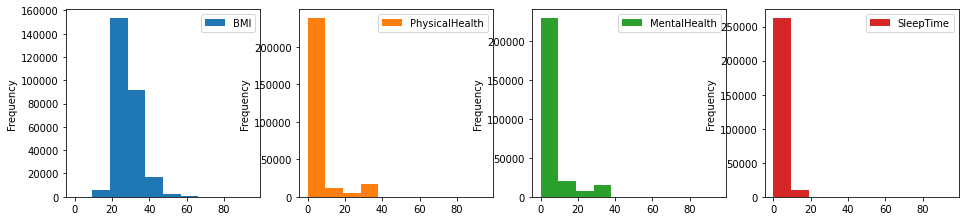

In [28]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

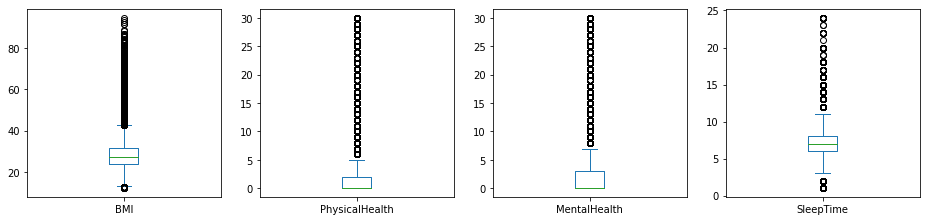

In [29]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

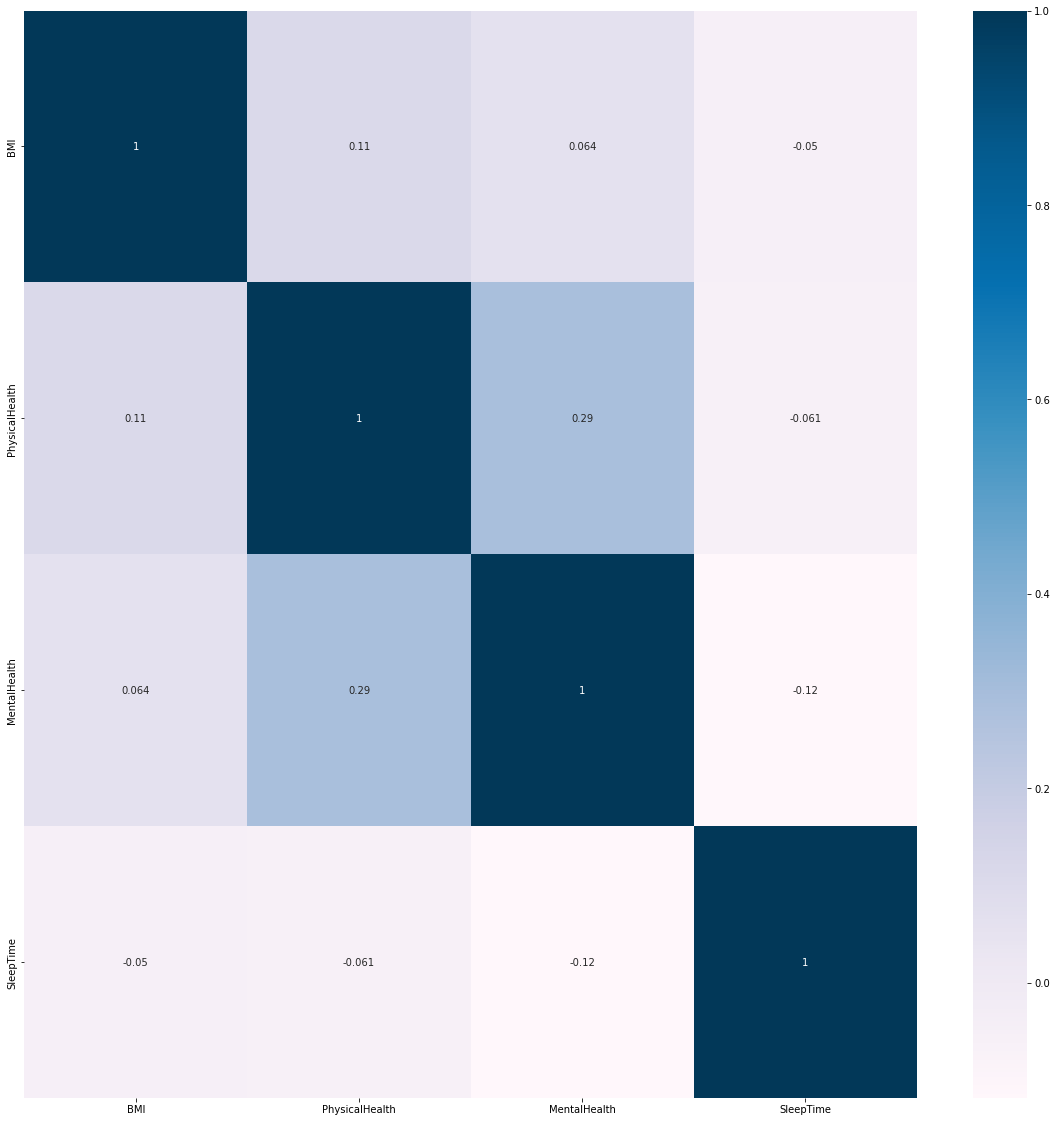

In [30]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [31]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [32]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling

In [33]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
    ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 4
Number of categorical columns: 13
Total number of columns in the feature dataframe: 17


In [34]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (271825, 17) to array_features_train.shape: (271825, 50)


### 3.b) Training Data Balancing

In [35]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [36]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [37]:
# Finalize the training dataset for the modeling activities
# array_features_train = df_features_train.to_numpy()
array_target_train = df_target_train.ravel()
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (271825, 50) array_target_train.shape: (271825,)


In [38]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [39]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [40]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=array_features_train.shape[1],
                    layer1_nodes=256, layer2_nodes=256, layer3_nodes=256, layer4_nodes=256, layer5_nodes=256,
                    layer1_dropout=0.25, layer2_dropout=0.25, layer3_dropout=0.25, layer4_dropout=0.25, layer5_dropout=0.25,
                    classifier_activation=CLASSIFIER_ACTIVATION, loss_param=DEFAULT_LOSS,
                    opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    nn_model = keras.Sequential([
        keras.layers.Dense(layer1_nodes, input_shape=(input_param,), activation='relu'),
        keras.layers.Dropout(layer1_dropout),
        keras.layers.Dense(layer2_nodes, activation='relu'),
        keras.layers.Dropout(layer2_dropout),
        keras.layers.Dense(layer3_nodes, activation='relu'),
        keras.layers.Dropout(layer3_dropout),
        keras.layers.Dense(layer4_nodes, activation='relu'),
        keras.layers.Dropout(layer4_dropout),
        keras.layers.Dense(layer5_nodes, activation='relu'),
        keras.layers.Dropout(layer5_dropout),
        keras.layers.Dense(1, activation=classifier_activation)
    ])
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [41]:
# start_time_module = datetime.now()
# reset_random()
# baseline_model = create_nn_model()
# baseline_model.fit(array_features_train, array_target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, verbose=1)
# print('Total time for model fitting and cross validating:', (datetime.now() - start_time_module))

In [42]:
# Initialize the default model and get a baseline result
start_time_module = datetime.now()
results = list()
iteration = 0
cv = RepeatedKFold(n_splits=N_FOLDS, n_repeats=N_ITERATIONS, random_state=RNG_SEED)
for train_ix, val_ix in cv.split(array_features_train):
    feature_train, feature_validation = array_features_train[train_ix], array_features_train[val_ix]
    target_train, target_validation = array_target_train[train_ix], array_target_train[val_ix]
    reset_random()
    baseline_model = create_nn_model()
    baseline_model.fit(feature_train, target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    model_metric = baseline_model.evaluate(feature_validation, target_validation, verbose=0)[1]
    iteration = iteration + 1
    print('Score from iteration %d >>> %.4f' % (iteration, model_metric))
    results.append(model_metric)
validation_score = np.mean(results)
validation_variance = np.std(results)
print('Average model score from all iterations: %.4f (%.4f)' % (validation_score, validation_variance))
print('Total time for model fitting and cross validating:', (datetime.now() - start_time_module))

2022-03-02 21:29:08.034551: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Score from iteration 1 >>> 0.8403
Score from iteration 2 >>> 0.8399
Score from iteration 3 >>> 0.8428
Score from iteration 4 >>> 0.8421
Score from iteration 5 >>> 0.8427
Average model score from all iterations: 0.8416 (0.0012)
Total time for model fitting and cross validating: 0:09:59.351871


### 4.b) Algorithm Tuning

In [43]:
# Not applicable for this iteration of the project

In [44]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [45]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [46]:
FINAL_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
final_model = create_nn_model(opt_param=FINAL_OPTIMIZER)
final_model.fit(array_features_train, array_target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, verbose=1)
final_model.summary()

Epoch 1/5
8495/8495 [==============================] - 32s 4ms/step - loss: 0.2359 - auc: 0.8247
Epoch 2/5
8495/8495 [==============================] - 32s 4ms/step - loss: 0.2322 - auc: 0.8308
Epoch 3/5
8495/8495 [==============================] - 32s 4ms/step - loss: 0.2322 - auc: 0.8315
Epoch 4/5
8495/8495 [==============================] - 32s 4ms/step - loss: 0.2324 - auc: 0.8311
Epoch 5/5
8495/8495 [==============================] - 32s 4ms/step - loss: 0.2322 - auc: 0.8319
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 256)               13056     
_________________________________________________________________
dropout_25 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               65792     
_______________________________

### 5.b) Load Test Dataset and Make Predictions

In [47]:
# Finalize the test dataset for the testing activities
array_features_test = preprocessor.transform(df_features_test)
array_target_test = df_target_test.ravel()
print("array_features_test.shape: {} array_target_test.shape: {}".format(array_features_test.shape, array_target_test.shape))

array_features_test.shape: (47970, 50) array_target_test.shape: (47970,)


In [48]:
# Make batched predictions
test_predictions = (final_model.predict(array_features_test) > 0.5).astype("int32").ravel()
print(test_predictions)

[0 0 0 ... 0 0 0]


In [49]:
print('Accuracy Score:', accuracy_score(array_target_test, test_predictions))
print('ROC/AUC Score:', roc_auc_score(array_target_test, test_predictions), '\n')
print(confusion_matrix(array_target_test, test_predictions), '\n')
print(classification_report(array_target_test, test_predictions))

Accuracy Score: 0.9151969981238274
ROC/AUC Score: 0.5060622384700743 

[[43851    13]
 [ 4055    51]] 

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     43864
           1       0.80      0.01      0.02      4106

    accuracy                           0.92     47970
   macro avg       0.86      0.51      0.49     47970
weighted avg       0.91      0.92      0.88     47970



In [50]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [51]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:12:49.231121
